In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Load the data
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_regular_season_data_2.csv')
print(data_path)
data = pd.read_csv(data_path)

/workspaces/Wharton-HS-Competition-Soccer-Playoff-Predictions/data/NSL_regular_season_data_2.csv


In [12]:
# Visualize the data
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        476 non-null    object 
 1   HomeTeam       476 non-null    object 
 2   AwayTeam       476 non-null    object 
 3   HomeScore      476 non-null    int64  
 4   AwayScore      476 non-null    int64  
 5   Home_xG        476 non-null    float64
 6   Away_xG        476 non-null    float64
 7   Home_shots     476 non-null    int64  
 8   Away_shots     476 non-null    int64  
 9   Home_corner    476 non-null    int64  
 10  Away_corner    476 non-null    int64  
 11  Home_PK_Goal   476 non-null    int64  
 12  Away_PK_Goal   476 non-null    int64  
 13  Home_PK_shots  476 non-null    int64  
 14  Away_PK_shots  476 non-null    int64  
 15  Home_ToP       476 non-null    float64
dtypes: float64(3), int64(10), object(3)
memory usage: 59.6+ KB


In [13]:
# Create a new column called 'Winner' that contains 1 if the home team wins, 0 if the away team wins
# data['Winner'] = data['HomeScore'] > data['AwayScore']
# data['Winner'] = data['Winner'].astype(int)

# Get all the games that involve team.
team_name = 'OAK'
team_home = data[data['HomeTeam'] == team_name]
team_away = data[data['AwayTeam'] == team_name]
team = pd.concat([team_home, team_away], axis=0)

# Create a new column called 'Winner' that contains 1 if team wins, 0 if team loses
team['is_home'] = np.where(team['HomeTeam'].eq(team_name), 1, 0)
team['Winner'] = np.where(team['is_home'], team['HomeScore'] > team['AwayScore'], team['AwayScore'] > team['HomeScore'])

# Redefine each of the home and away games to be relative to team
# team['curr_xG'] = np.where(team['is_home'], team['Home_xG'], team['Away_xG'])
# team['opp_xG'] = np.where(team['is_home'], team['Away_xG'], team['Home_xG'])
team['curr_shots'] = np.where(team['is_home'], team['Home_shots'], team['Away_shots'])
team['opp_shots'] = np.where(team['is_home'], team['Away_shots'], team['Home_shots'])
team['curr_corner'] = np.where(team['is_home'], team['Home_corner'], team['Away_corner'])
team['opp_corner'] = np.where(team['is_home'], team['Away_corner'], team['Home_corner'])
team['curr_PK_Goal'] = np.where(team['is_home'], team['Home_PK_Goal'], team['Away_PK_Goal'])
team['opp_PK_Goal'] = np.where(team['is_home'], team['Away_PK_Goal'], team['Home_PK_Goal'])
team['curr_PK_shots'] = np.where(team['is_home'], team['Home_PK_shots'], team['Away_PK_shots'])
team['opp_PK_shots'] = np.where(team['is_home'], team['Away_PK_shots'], team['Home_PK_shots'])
team['possesion'] = np.where(team['is_home'], team['Home_ToP'], 1 - team['Home_ToP'])

# Drop all home and away columns
team = team.drop(['game_id', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG',
                  'Home_shots', 'Away_shots', 'Home_corner', 'Away_corner', 'Home_PK_Goal', 'Away_PK_Goal',
                  'Home_PK_shots', 'Away_PK_shots', 'Home_ToP'], axis=1)

team.head()

,is_home,Winner,curr_shots,opp_shots,curr_corner,opp_corner,curr_PK_Goal,opp_PK_Goal,curr_PK_shots,opp_PK_shots,possesion
11,1,False,12,19,7,5,0,0,0,0,0.47
27,1,False,21,10,4,2,0,0,0,0,0.43
60,1,False,12,14,3,2,0,0,0,0,0.62
79,1,False,4,18,5,4,0,0,0,0,0.54
125,1,False,16,19,7,3,0,0,0,0,0.60


In [14]:
# Visualize the mean and spread of the data
team.describe()

,is_home,curr_shots,opp_shots,curr_corner,opp_corner,curr_PK_Goal,opp_PK_Goal,curr_PK_shots,opp_PK_shots,possesion
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0,34.000000,34.000000,34.000000
mean,0.500000,13.205882,12.441176,4.735294,4.823529,0.029412,0.0,0.205882,0.147059,0.464118
std,0.507519,5.682399,6.150591,2.643561,2.656845,0.171499,0.0,0.478597,0.359491,0.083996
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.320000
25%,0.000000,11.000000,9.000000,2.250000,3.000000,0.000000,0.0,0.000000,0.000000,0.412500
50%,0.500000,13.500000,11.500000,4.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.455000
75%,1.000000,16.750000,14.000000,7.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.522500
max,1.000000,23.000000,28.000000,11.000000,11.000000,1.000000,0.0,2.000000,1.000000,0.620000


Winner
False    19
True     15
Name: count, dtype: int64
Winner
False    1000
True     1000
Name: count, dtype: int64


<Axes: >

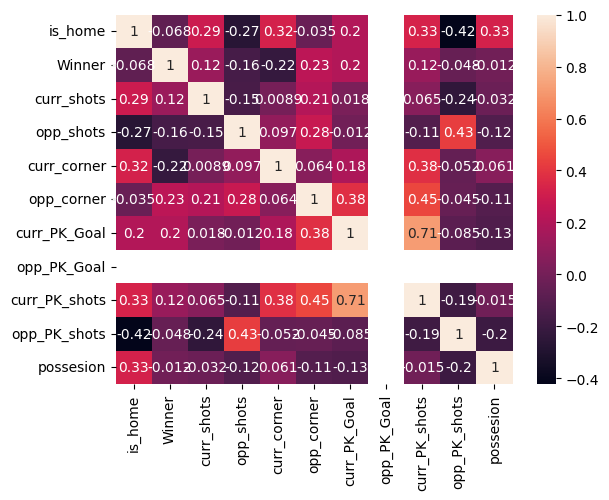

In [15]:
# Make sure that the data is balanced
print(team['Winner'].value_counts())

# Resample the data
team_0 = team[team['Winner'] == 0]
team_1 = team[team['Winner'] == 1]
samples = 1000
team_0_resampled = team_0.sample(samples, replace=True)
team_1_resampled = team_1.sample(samples, replace=True)
team = pd.concat([team_0_resampled, team_1_resampled], axis=0)
print(team['Winner'].value_counts())

# Find what features are most correlated with the winner
corr = team.corr()

# Create a heatmap
sns.heatmap(corr, annot=True)

              precision    recall  f1-score   support

       False       0.73      0.74      0.74       400
        True       0.74      0.73      0.73       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800



<Axes: >

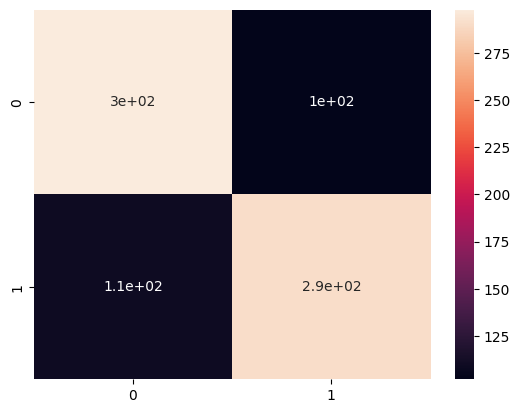

In [16]:
# Split the data into a feature matrix and a target vector
X = team.drop('Winner', axis=1).values
y = team['Winner'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Create a logistic regression model
logreg = LogisticRegression()

# Fit the model
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Show the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)



              precision    recall  f1-score   support

       False       1.00      1.00      1.00       400
        True       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



<Axes: >

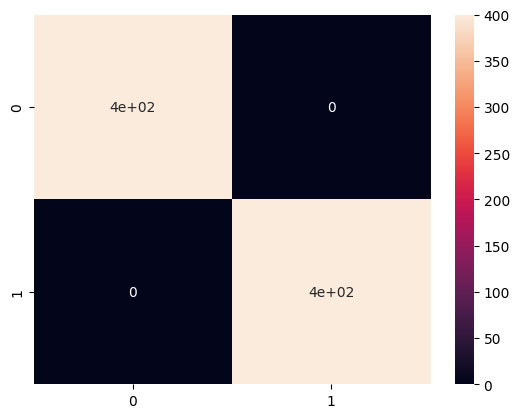

In [17]:
# Try a different model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

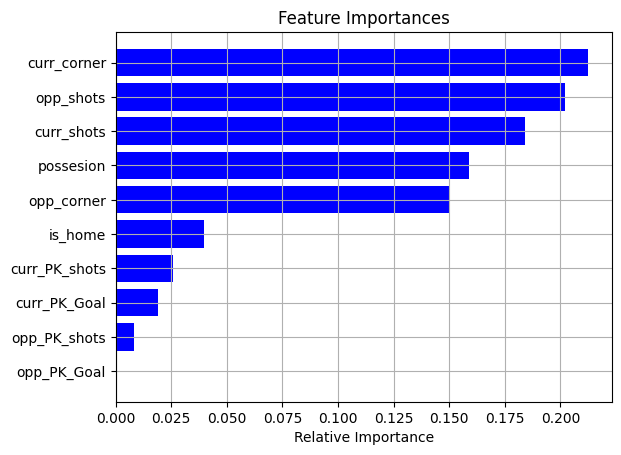

In [18]:
# Get insight about the random forest model
importances = rf.feature_importances_
features = team.drop('Winner', axis=1).columns
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       400
        True       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



<Axes: >

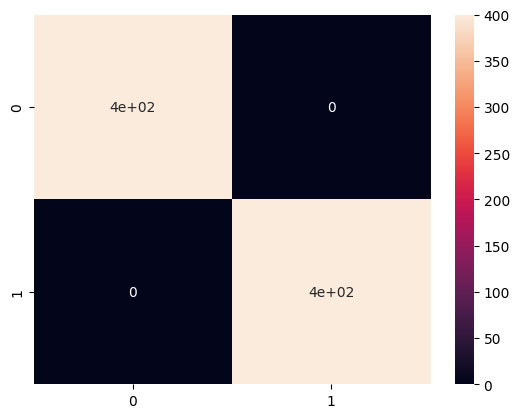

In [19]:
# Try a different model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.887 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.900 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.887 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.887 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.858 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.792 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.01

<Axes: >

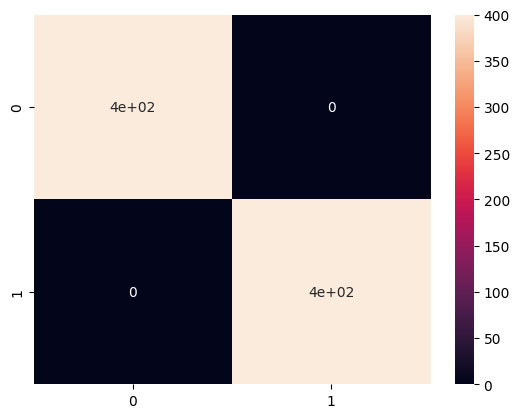

In [20]:
# Get insight about the SVC model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)
